# emcee and Bayesian Software Tools

## Review of emcee

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt

In [2]:
c_true = (5, 0.12, 11/4)
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 1 + 5 * np.random.rand(N)
y = c_true[0] + c_true[1]*x + c_true[2]*x**2
y += yerr * np.random.randn(N)

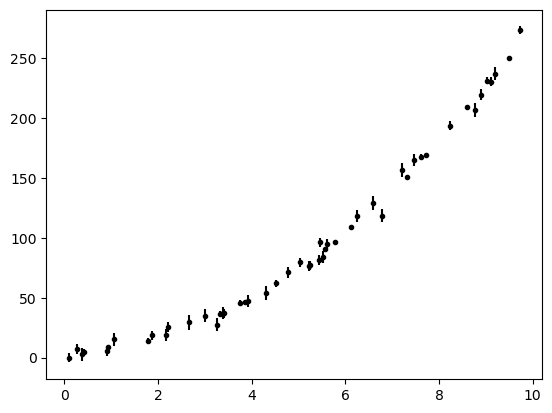

In [3]:
plt.errorbar(x, y, yerr=yerr, fmt="k.");

In [4]:
def log_likelihood(theta, x, y, yerr):
    theory = theta[0] + theta[1] * x + theta[2] * x**2
    return -0.5 * np.sum((y-theory) **2 / yerr**2 + np.log(yerr))

def log_prior(theta):
    if -10 < theta[0] < 10 and -10 < theta[1] < 10 and -10 < theta[2] < 10:
       return 0.0
    return - np.inf

def log_prob(theta, x, y, err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [5]:
nwalkers, ndim = 32, 3
pos = [0, 0, 0] + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:02<00:00, 1804.67it/s]


## Arviz: Exploratory analysis of Bayesian models

https://python.arviz.org/en/latest/index.html

In [6]:
import arviz as az

In [7]:
idata = az.from_emcee(sampler, var_names=["c0", "c1", "c2"])

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

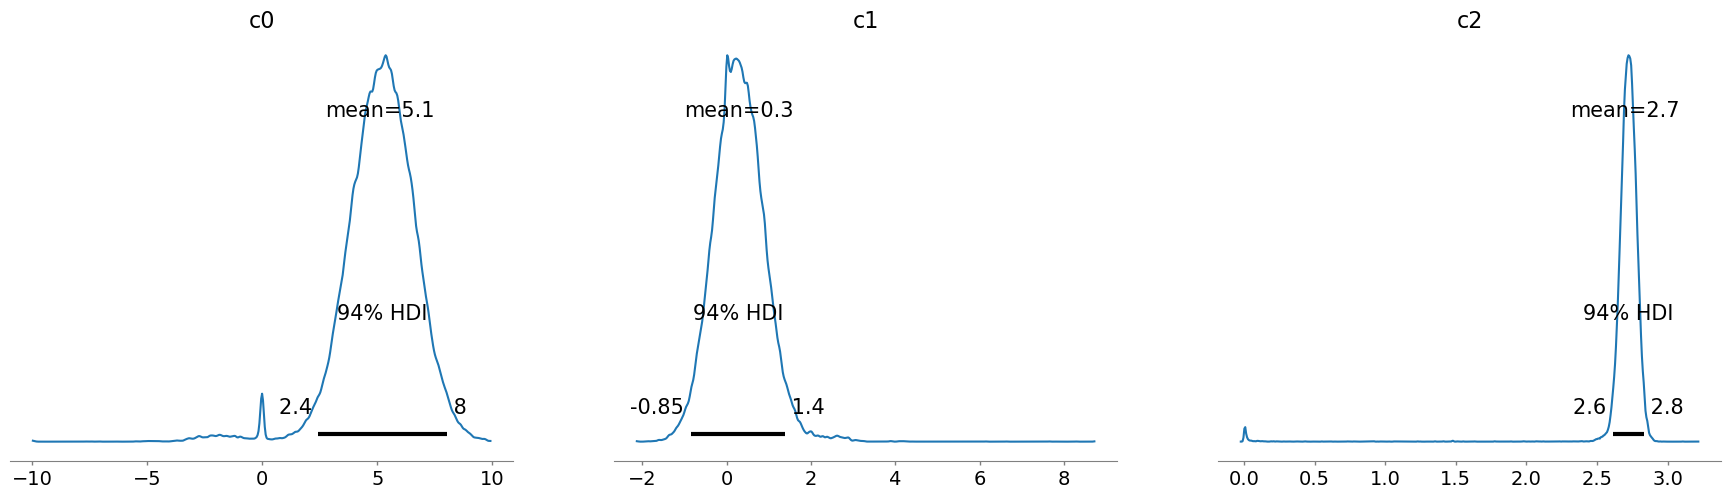

In [9]:
az.plot_posterior(idata, var_names=["c0", "c1", "c2"]);

array([[<Axes: title={'center': 'c0'}>, <Axes: title={'center': 'c0'}>],
       [<Axes: title={'center': 'c2'}>, <Axes: title={'center': 'c2'}>]],
      dtype=object)

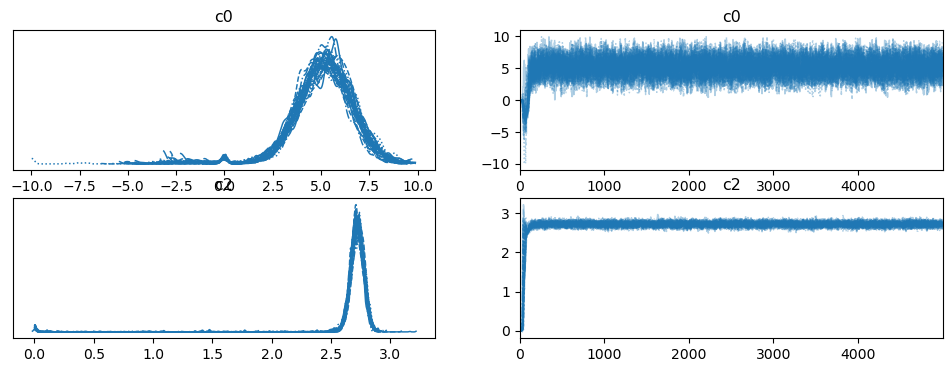

In [10]:
az.plot_trace(idata, var_names=("c0", "c2"));

## blobs: unlock sample stats, posterior predictive and miscellanea

We will see how to do this first with `emcee`, but define these terms with `pymce`.

In [11]:
def log_prob_blobs(theta, x, y, err):
    lp = log_prior(theta)
    like_vector = log_likelihood(theta, x, y, yerr)
    like = np.sum(like_vector)
    return lp + like, like_vector

In [12]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_blobs, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:03<00:00, 1482.10it/s]


In [13]:
idata = az.from_emcee(
    sampler,
    var_names=["c0", "c1", "c2"],
    blob_names=["log_likelihood"],
)
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## PyMC